In [1]:
import numpy as np
import random
import networkx as nx
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

torch.cuda.get_device_name(0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
# ________________________ALL FUNCTIONS AND CLASSES ___________________________


def make_network(m,n, noise_low, noise_high):
    O = nx.triangular_lattice_graph(m,n, periodic=False, with_positions=True, create_using=None)
    G = nx.convert_node_labels_to_integers(O)
    #nx.draw(G, with_labels=True)
    #plt.show()
    print(G)
    pos_dict = nx.get_node_attributes(G, "pos")

    num_nodes = len(G.nodes)
    num_springs = len(G.edges)
    
    x = torch.zeros(num_nodes, 2)
    values = list(pos_dict.values())
    for i in range(len(values)):
        x[i][0] = values[i][0]
        x[i][1] = values[i][1]
    
    # add noise to initial layout
    torch.random.manual_seed(8)
    base_x = x.detach().clone()
    noise = (noise_low - noise_high) * torch.rand(num_nodes, 2) + noise_high
    x = x+noise
    
    x.requires_grad = True
    
    indices = []
    for i, (node1,node2) in enumerate(G.edges):
        indices.append([node1,node2])

    return num_nodes, num_springs, x, indices, base_x

def make_incidence(indices, num_vertices):
    # this creates a dense matrix (incidence), but
    # sparse matrices or convolutions might be more appropriate
    # in certain cases
    num_springs = len(indices)
    incidence = torch.zeros(num_springs, num_vertices, dtype=torch.float32)
    for i, item in enumerate(indices):
        i1, i2 = item
        incidence[i, i1] = 1
        incidence[i, i2] = -1
    return incidence

def get_l0(num_springs, range_num, noise_scale = 0):
    l0 = torch.rand(num_springs) * range_num
    # add noise
    noise = (-noise_scale - noise_scale) * torch.rand(num_springs) + noise_scale
    buffer = torch.ones(num_springs) * noise_scale
    l0 = l0 + noise + buffer
    return l0

def get_k(num_springs, range_num):
    k = torch.rand(num_springs) * range_num
    #k = torch.ones(num_springs, dtype=torch.float32)
    #k = k + noise
    return k

def get_source_springs(nsprings, nsource_springs):
    s_springs = np.random.choice(nsprings, size=nsource_springs, replace=False, p=None)
    return s_springs

def get_target_springs(nsprings, ntarget_springs, s_springs):
    to_exclude = s_springs # cannot be the same springs as the source springs
    t_springs = random.sample(list(set([x for x in range(nsprings)]) - set(to_exclude)), k = ntarget_springs)
    return t_springs

def create_spring_mask(s_springs, t_springs, indices, nodes, free_mode=True):
    # using the random springs, get the corresponding nodes and create a mask
    mask = np.zeros(nodes,)
    for spring_index in s_springs:
        node1, node2 = indices[spring_index]
        mask[node1] = 1
        mask[node2] = 1
    if free_mode == False:
        for spring_index in t_springs:
            node1, node2 = indices[spring_index]
            mask[node1] = 1
            mask[node2] = 1
    return mask


def clamp_s_spring_length(spring_network, input_strain, spring, indices, x):
    
    input_length = input_strain + 1
    
    # get the corresponding nodes for the spring
    node1, node2 = indices[spring]
        
    x1 = x[node1][0]
    x2 = x[node2][0]
        
    y1 = x[node1][1]
    y2 = x[node2][1]
        
    delta_y = y2 - y1
    delta_x = x2 - x1
    
    current_length = spring_network.measure_spring_length(x, spring)
    ratio = input_length / current_length
    
    new_y = ratio * delta_y
    new_x = ratio * delta_x
    
    with torch.no_grad():
        x[node2][1] = x[node1][1] + new_y
        x[node2][0] = x[node1][0] + new_x
    
    return x

def clamp_spring_length2(spring_network, input_strain, spring, indices, x, l0):
    
    input_length = (l0[spring]*(input_strain + 1))
    
    # get the corresponding nodes for the spring
    node1, node2 = indices[spring]
        
    x1 = x[node1][0]
    x2 = x[node2][0]
        
    y1 = x[node1][1]
    y2 = x[node2][1]
        
    delta_y = y2 - y1
    delta_x = x2 - x1
    
    current_length = spring_network.measure_spring_length(x, spring)
    ratio = input_length / current_length
    
    new_y = ratio * delta_y
    new_x = ratio * delta_x
    
    with torch.no_grad():
        x[node2][1] = x[node1][1] + new_y
        x[node2][0] = x[node1][0] + new_x
        
        l0[spring] = input_length
        k[spring] = 1e10
    
    return x

def clamp_spring_length(spring_network, input_strain, spring, indices, x, l0):
 
    input_length = input_strain
    
    # get the corresponding nodes for the spring
    node1, node2 = indices[spring]
        
    x1 = x[node1][0]
    x2 = x[node2][0]
        
    y1 = x[node1][1]
    y2 = x[node2][1]
        
    delta_y = y2 - y1
    delta_x = x2 - x1
    
    current_length = spring_network.measure_spring_length(x, spring)
    ratio = input_length / current_length
    
    new_y = ratio * delta_y
    new_x = ratio * delta_x
    
    with torch.no_grad():
        x[node2][1] = x[node1][1] + new_y
        x[node2][0] = x[node1][0] + new_x
        
        l0[spring] = input_length
        k[spring] = 1e10
    
    return x

# main simulation loop
def run_to_equil(mask, x, optimizer, network, iterations):
    
  energies = np.zeros(iterations)
  for i in range(iterations):
    #if i > 1000:
    #    optimizer = torch.optim.Adam([x], lr=1e-3)
    optimizer.zero_grad()
    loss = network.energy(x).sum() # sum for total energy
    loss.backward()
    #x.grad[mask !=0] = torch.zeros_like(x.grad[mask !=0])
    optimizer.step()
    energies[i] = loss
  return energies

class MSD(nn.Module):
    def __init__(self, indices, l0, k, num_vertices):
        super().__init__()
        self.indices = indices
        self.register_buffer("incidence", make_incidence(self.indices, num_vertices))
        self.register_buffer("l0", l0)
        self.register_buffer("k", k)
    
    def measure_spring_length(self, x, spring_index):
        d = self.incidence.mm(x)
        q = d.pow(2).sum(1)
        l = q.sqrt() 
        l = l[spring_index] # get the length of a particular spring by indexing
        return l
        
    def measure_spring_strain(self, x, spring_index):
        # strain = change in length / original length
        d = self.incidence.mm(x)
        q = d.pow(2).sum(1)
        l = q.sqrt()
        strain = (l / self.l0) - 1
        #dl = (l - self.l0)
        strain = strain[spring_index] # get the strain of a particular spring by indexing
        return strain
    
    def measure_length_change(self, x):
        d = self.incidence.mm(x)
        q = d.pow(2).sum(1)
        l = q.sqrt()
        dl = (l - self.l0)
        return dl
        
    
    def energy(self, x):
        d = self.incidence.float().mm(x) 
        q = d.pow(2).sum(1)
        l = q.sqrt()
        #l = (q + 1e-6).sqrt()
        dl = l - self.l0
        #e = 0.5 * (self.k * dl.pow(2)).sum()
        e = 0.5 * (self.k * dl.pow(2)) # without summing, returns vector of size = num_springs
        return e
    
    def partial_e(self, x):
      # k * (x - l)
      d = self.incidence.float().mm(x) 
      q = d.pow(2).sum(1)
      l = q.sqrt()
      dl = l - self.l0
      partial_e = self.k * dl
      return partial_e

    def partial_e_k(self, x):
      # k * (x - l)^2
      d = self.incidence.float().mm(x) 
      q = d.pow(2).sum(1)
      l = q.sqrt()
      dl = l - self.l0
      partial_e_k = self.k * dl.pow(2)
      return partial_e_k

In [3]:

#_______________________________ INIT NETWORK__________________________________

# set seeds if you want the same network everytime
seed = 8
torch.random.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create network
noise_low=-0.1
noise_high=0.1
num_nodes, num_springs, x, indices, base_x = make_network(3, 3, noise_low=noise_low, noise_high=noise_high)
num_springs = len(indices)

# copy initial conditions so that the network can be reinitialised each time
x_init = x.detach().clone()

# initialise learning degrees of freedom
# noise scale should not be greater than 1
l0 = get_l0(num_springs, 10, noise_scale=10)
k = get_k(num_springs, 50)
#l0 = torch.ones(num_springs)
#k = torch.ones(num_springs)


# select source springs
num_source_springs = 1
s_springs = get_source_springs(num_springs, num_source_springs)
print(s_springs) 
# source spring equil length needs to always be 1
l0[s_springs] = 1


# select target springs 
num_targets = 1 # if we are only doing MNIST with 0s and 1s...
t_springs = get_target_springs(num_springs, num_targets, s_springs)
#set_value = 13
#t_springs = np.array([set_value])
print(t_springs)

mask1 = create_spring_mask(s_springs, t_springs, indices, num_nodes)
mask2 = create_spring_mask(s_springs, t_springs, indices, num_nodes, free_mode=False)

# instantiate network
spring_network = MSD(indices, l0, k, num_nodes)

Graph with 10 nodes and 18 edges
[14]
[7]


In [4]:


"""
_________________COUPLED LEARNING RULE: ALLOSTERY______________________
"""
    
def get_nudged_target(free_strain, desired_strain, eta):
    error = 0.5 * torch.pow((desired_strain - free_strain), 2)
    if (free_strain > desired_strain):
        error = error * -1
        
    # or could just do 
    nudged_strain = free_strain + (eta* (desired_strain-free_strain))
    length = l0[t_springs[0]] * (nudged_strain + 1)
    #length = free_strain + (eta * error)
    return length, error


l0_init_s = l0[s_springs[0]].detach().clone()
l0_init_t = l0[t_springs[0]].detach().clone()


#alpha = 5e-4
alpha = 1e-3 

eta = 1e-1
epochs = 100
#run_time = 200000
run_time = 20000

mu, sigma = 0, 2.5
factor =  np.random.normal(mu, sigma, 1)[0]
#print(factor)
input_strain = factor + 5
sigma2 = 0.2*sigma
factor2 =  np.random.normal(mu, sigma2, 1)[0]
#print(factor2)
target = factor2 + 5

print('s and t')
print(input_strain)
print(target)


lengths_list = np.zeros(epochs)
target_l0s = np.zeros(epochs)

errors = np.zeros(epochs)
energies_list = np.zeros(epochs)
partial_energies_list = np.zeros(epochs)

for i in range(epochs):

    print(f'iteration no.: {i}')

    print('l0 of the target spring', l0[t_springs[0]])

    target_l0s[i] = l0[t_springs[0]].item()
    
    with torch.no_grad():
      # reset x
      x = x_init.detach().clone()
      x.requires_grad = True

    # PHASE 1: run to equilibrium (free state)
    
    k_orig = k.detach().clone()
    l0_orig = l0.detach().clone()
    
    # clamp source inputs 
    x = clamp_spring_length(spring_network, input_strain, s_springs[0], indices, x, l0)

    # instantiate the optimizer    
    optimizer = torch.optim.Adagrad([x], lr=1e-1)

    # inference
    energies = run_to_equil(mask1, x, optimizer, spring_network, iterations=run_time)
    energies_list[i] = energies[-1]
    partial_energies_list[i] = spring_network.partial_e(x).sum()
    free_state_energy = spring_network.energy(x).sum()
    #print(energies[0], energies[-1])
    #print(spring_network.measure_spring_strain(x, t_springs))
    free_target_len = spring_network.measure_spring_length(x, t_springs)
    free_target_strain = spring_network.measure_spring_strain(x, t_springs)
    print('length',free_target_len.item())

    lengths_list[i] = free_target_len.item()

    print('strain',free_target_strain.item())
    free_state_dl = spring_network.measure_length_change(x)
    print('free_state_energy',free_state_energy)
    
    # PHASE 2: now clamp target at nudged length and run to second equilibrium

    # clamp target
    #target_len_nudged, error = get_nudged_target(free_target_len, target, eta)
    target_len_nudged, error = get_nudged_target(free_target_strain, target, eta)

    print('_________error', error.item())
    errors[i] = error.item()

    x = clamp_spring_length(spring_network, target_len_nudged, t_springs[0], indices, x, l0)
   
    energies2 = run_to_equil(mask1, x, optimizer, spring_network, iterations=run_time)
    """
    take this below bit out as biologically implausible - if it has no affect?
    """
    # reinstate the original ks and l0s to get a measure of the energy function
    with torch.no_grad():
        k[t_springs[0]] = k_orig[t_springs[0]] 
        l0[t_springs[0]] = l0_orig[t_springs[0]]
    
    spring_network.l0 = l0
    spring_network.k = k
    clamp_state_energy = spring_network.energy(x).sum()
    print('clamp_state_energy',clamp_state_energy)
    
    # PHASE 3: weight update 
    
    clamped_state_dl = spring_network.measure_length_change(x)
    
    with torch.no_grad():
        dls = free_state_dl - clamped_state_dl
        #dls = np.linalg.norm(free_state_dl - clamped_state_dl)
        all_strains = torch.mul(k, dls)

        # __________if I want to check whether its worse at learning when target cannot learn...
        #target_springs_l0 = l0[t_springs[0]].detach().clone()

        # weight update
        l0 = l0 + (alpha * (1/eta)* all_strains)
        l0[l0<0] = 1e-6

        # __________if I want to check whether its worse at learning when target cannot learn...
        #l0[t_springs[0]] = target_springs_l0


    spring_network.l0 = l0
   




s and t
8.936084809721873
5.130911414813278
iteration no.: 0
l0 of the target spring tensor(5.5966)
length 7.969210624694824
strain 0.42392992973327637
free_state_energy tensor(346.3716, grad_fn=<SumBackward0>)
_________error 11.077837944030762
clamp_state_energy tensor(368.1424, grad_fn=<SumBackward0>)
iteration no.: 1
l0 of the target spring tensor(5.2536)
length 7.527449131011963
strain 0.43280911445617676
free_state_energy tensor(331.5425, grad_fn=<SumBackward0>)
_________error 11.036081314086914
clamp_state_energy tensor(346.2207, grad_fn=<SumBackward0>)
iteration no.: 2
l0 of the target spring tensor(4.9323)
length 7.107660293579102
strain 0.44105613231658936
free_state_energy tensor(317.1154, grad_fn=<SumBackward0>)
_________error 10.997370719909668
clamp_state_energy tensor(323.7551, grad_fn=<SumBackward0>)
iteration no.: 3
l0 of the target spring tensor(4.6311)
length 6.707282066345215
strain 0.4483211040496826
free_state_energy tensor(302.8032, grad_fn=<SumBackward0>)
_______

In [5]:
#np.save(f"drive/My Drive/project_data/cl_allostery/errors_folder/errors_{seed}_repeated", errors)
#np.save(f"drive/My Drive/project_data/cl_allostery/l0s/target_l0s_{seed}_repeated", target_l0s)
#np.save(f"drive/My Drive/project_data/cl_allostery/lens/lengths_list_{seed}_repeated", lengths_list)
#np.save(f"drive/My Drive/project_data/cl_allostery/trained_l0s/final_l0s_{seed}_repeated", spring_network.l0)


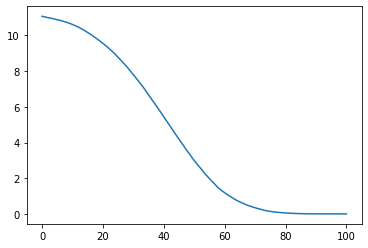

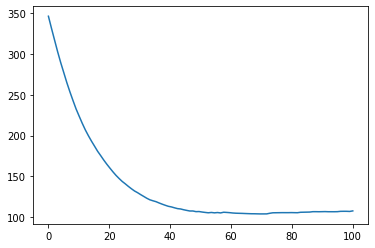

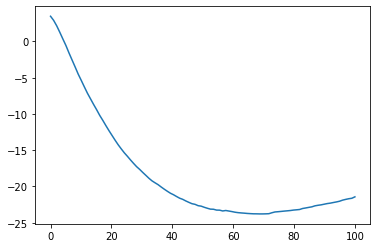

In [6]:
plt.plot(np.linspace(0,epochs,epochs), errors)
plt.show()

plt.plot(np.linspace(0,epochs,epochs), energies_list)
plt.show()

plt.plot(np.linspace(0,epochs,epochs), partial_energies_list)
plt.show()

In [7]:
strains_list = []
lens_list = []

inputs_list =  [1,2,3,4,5,6,7,8,9,10]

spring_network.l0 = l0

for inp in inputs_list:
    
    with torch.no_grad():
      # reset x
      x = x_init.detach().clone()
      x.requires_grad = True

    # PHASE 1: run to equilibrium (free state)
    
    k_orig = k.detach().clone()
    l0_orig = l0.detach().clone()
    
    # clamp source inputs 
    x = clamp_spring_length(spring_network, inp, s_springs[0], indices, x, l0)

    # instantiate the optimizer    
    optimizer = torch.optim.Adagrad([x], lr=1e-1)

    # inference
    energies = run_to_equil(mask1, x, optimizer, spring_network, iterations=run_time)
    free_target_len = spring_network.measure_spring_length(x, t_springs)
    free_target_strain = spring_network.measure_spring_strain(x, t_springs)
    #print('length',free_target_len.item())
    lens_list.append(free_target_len.item())

    #print('strain',free_target_strain.item())
    strains_list.append(free_target_strain.item())


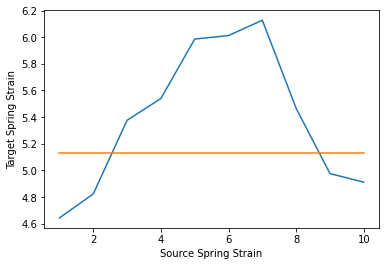

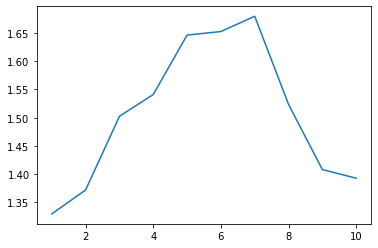

In [8]:
plt.plot(inputs_list, strains_list)
plt.xlabel("Source Spring Strain")
plt.ylabel("Target Spring Strain")
actual_strain = np.full(len(inputs_list),target)
plt.plot(inputs_list,actual_strain)
plt.show()

plt.plot(inputs_list, lens_list)
plt.show()